In [ ]:
import pandas as pd

# Load test data
test = pd.read_csv("train_data_cleaned.csv")

# Identify call and put IV columns
call_iv_cols = [col for col in test.columns if col.startswith("call_iv_")]
put_iv_cols = [col for col in test.columns if col.startswith("put_iv_")]

# Calculate number of non-NaN values per row for each
test['call_iv_count'] = test[call_iv_cols].notna().sum(axis=1)
test['put_iv_count'] = test[put_iv_cols].notna().sum(axis=1)

# Calculate the average across all rows
avg_call_iv_present = test['call_iv_count'].mean()
avg_put_iv_present = test['put_iv_count'].mean()

print(f"Average number of call IV values per row: {avg_call_iv_present:.2f}")
print(f"Average number of put IV values per row: {avg_put_iv_present:.2f}")


Average number of call IV values per row: 13.00
Average number of put IV values per row: 13.00


In [6]:
import pandas as pd

# Load test data
test = pd.read_csv("train_residuals_only_masked.csv")

# Identify IV columns
iv_cols = [col for col in test.columns if col.startswith("iv_")]

# Count non-NaN IVs per row
test['iv_count'] = test[iv_cols].notna().sum(axis=1)

# Calculate average number of IVs present per row
avg_iv_present = test['iv_count'].mean()

print(f"Average number of IV values per row: {avg_iv_present:.2f}")


Average number of IV values per row: 18.00


In [7]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('v4_distance_corrected.csv')

# Count null values per column
null_counts = df.isnull().sum()

# Print the result
print("Null values per column:")
print(null_counts)

# Optionally, total null values in the entire DataFrame
total_nulls = df.isnull().sum().sum()
print(f"\nTotal null values in the entire CSV: {total_nulls}")


Null values per column:
timestamp        0
call_iv_24000    0
call_iv_24100    0
call_iv_24200    0
call_iv_24300    0
call_iv_24400    0
call_iv_24500    0
call_iv_24600    0
call_iv_24700    0
call_iv_24800    0
call_iv_24900    0
call_iv_25000    0
call_iv_25100    0
call_iv_25200    0
call_iv_25300    0
call_iv_25400    0
call_iv_25500    0
call_iv_25600    0
call_iv_25700    0
call_iv_25800    0
call_iv_25900    0
call_iv_26000    0
call_iv_26100    0
call_iv_26200    0
call_iv_26300    0
call_iv_26400    0
call_iv_26500    0
put_iv_23000     0
put_iv_23100     0
put_iv_23200     0
put_iv_23300     0
put_iv_23400     0
put_iv_23500     0
put_iv_23600     0
put_iv_23700     0
put_iv_23800     0
put_iv_23900     0
put_iv_24000     0
put_iv_24100     0
put_iv_24200     0
put_iv_24300     0
put_iv_24400     0
put_iv_24500     0
put_iv_24600     0
put_iv_24700     0
put_iv_24800     0
put_iv_24900     0
put_iv_25000     0
put_iv_25100     0
put_iv_25200     0
put_iv_25300     0
put_iv_

In [17]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('new_train_residuals_masked_filtered.csv')

# Count null values per column
null_counts = df.isnull().sum()
total_nulls = null_counts.sum()

# Write to a text file
with open('null_counts_report.txt', 'w') as f:
    f.write("Null values per column:\n")
    f.write(null_counts.to_string())
    f.write(f"\n\nTotal null values in the entire CSV: {total_nulls}")


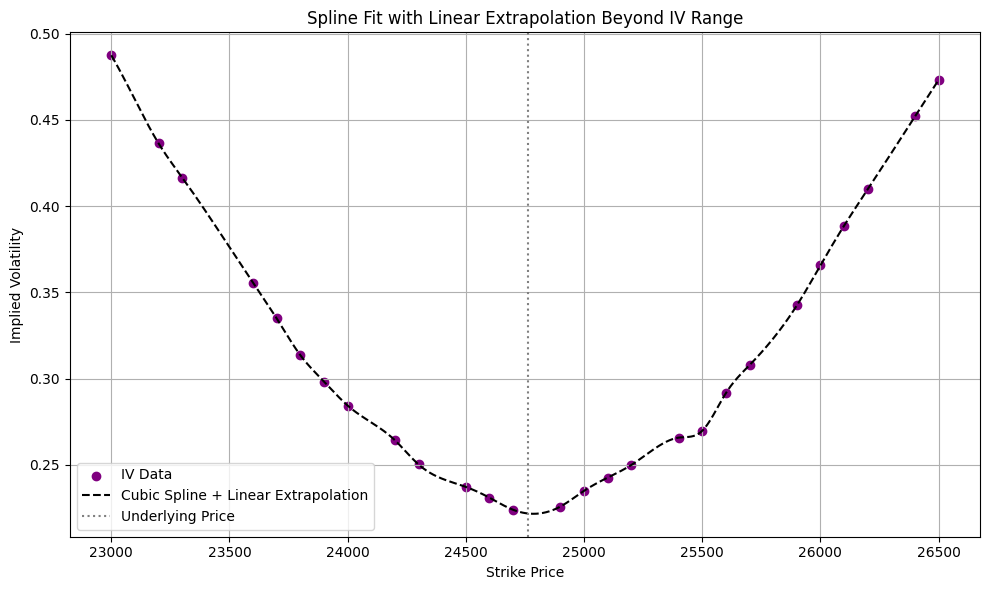

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.interpolate import CubicSpline

# Load data
df = pd.read_csv('test_data.csv')
row = df.iloc[995]  # Pick a row to analyze

# Extract IVs
iv_data = {}
for col in row.index:
    match = re.match(r'(call_iv_|put_iv_)(\d+)', col)
    if match:
        strike = int(match.group(2))
        iv = row[col]
        if pd.notna(iv):
            iv_data[strike] = iv

# Sort and convert to arrays
strikes, ivs = zip(*sorted(iv_data.items()))
strikes = np.array(strikes)
ivs = np.array(ivs)

# Underlying
underlying_price = row['underlying']

# Find closest point to underlying
idx_underlying = np.abs(strikes - underlying_price).argmin()
strike_underlying = strikes[idx_underlying]
iv_underlying = ivs[idx_underlying]

# Estimate endpoint slopes
slope_left = 1.5 * (iv_underlying - ivs[0]) / (strike_underlying - strikes[0])
slope_right = 1.5 * (ivs[-1] - iv_underlying) / (strikes[-1] - strike_underlying)

# Fit spline (interior only)
spline = CubicSpline(strikes, ivs, bc_type=((1, slope_left), (1, slope_right)), extrapolate=False)

# Smooth x range
x_smooth = np.linspace(23000, 26500, 1000)
y_smooth = np.empty_like(x_smooth)

# Linear extrapolation on left using first 2 points
s1, s2 = strikes[0], strikes[1]
iv1, iv2 = ivs[0], ivs[1]
slope_left_linear = (iv2 - iv1) / (s2 - s1)

# Linear extrapolation on right using last 2 points
sN_1, sN = strikes[-2], strikes[-1]
ivN_1, ivN = ivs[-2], ivs[-1]
slope_right_linear = (ivN - ivN_1) / (sN - sN_1)

# Fill y_smooth with appropriate values
for i, x in enumerate(x_smooth):
    if x < strikes[0]:
        y_smooth[i] = iv1 + slope_left_linear * (x - s1)
    elif x > strikes[-1]:
        y_smooth[i] = ivN + slope_right_linear * (x - sN)
    else:
        y_smooth[i] = spline(x)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(strikes, ivs, color='purple', label='IV Data')
plt.plot(x_smooth, y_smooth, color='black', linestyle='--', label='Cubic Spline + Linear Extrapolation')
plt.axvline(underlying_price, color='gray', linestyle=':', label='Underlying Price')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Spline Fit with Linear Extrapolation Beyond IV Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


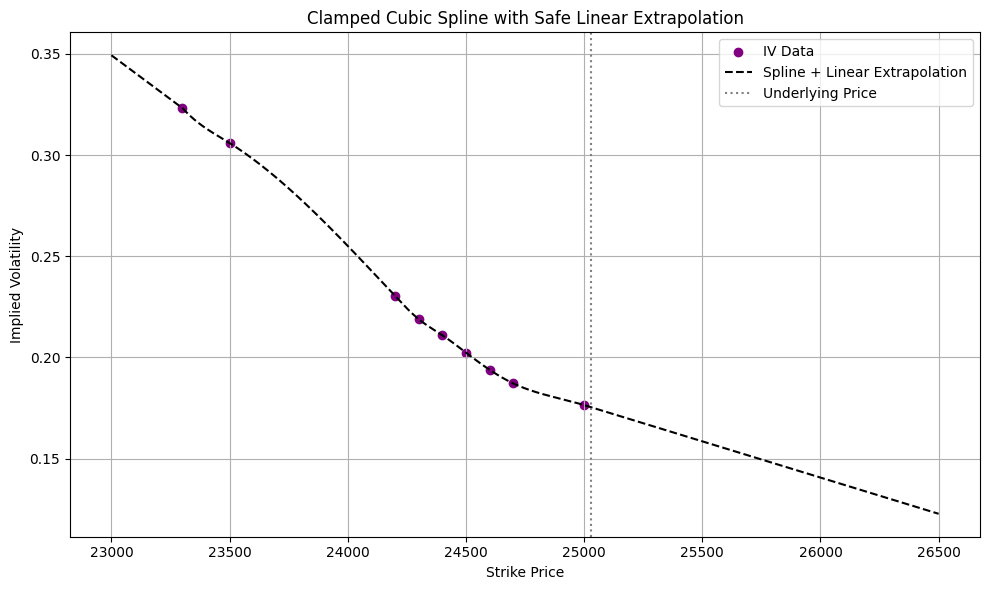

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.interpolate import CubicSpline

# Load data
df = pd.read_csv('test_data.csv')
row = df.iloc[5741]  # Pick a row to analyze

# Extract IVs
iv_data = {}
for col in row.index:
    match = re.match(r'(call_iv_|put_iv_)(\d+)', col)
    if match:
        strike = int(match.group(2))
        iv = row[col]
        if pd.notna(iv):
            iv_data[strike] = iv

# Sort and convert to arrays
strikes, ivs = zip(*sorted(iv_data.items()))
strikes = np.array(strikes)
ivs = np.array(ivs)

# Extract underlying price
underlying_price = row['underlying']
idx_underlying = np.abs(strikes - underlying_price).argmin()
strike_underlying = strikes[idx_underlying]
iv_underlying = ivs[idx_underlying]

# Robust slope estimation on left
for i in range(1, len(strikes)):
    if strikes[i] != strikes[0]:
        slope_left_linear = (ivs[i] - ivs[0]) / (strikes[i] - strikes[0])
        if strike_underlying != strikes[0]:
            slope_left = 1.5 * (iv_underlying - ivs[0]) / (strike_underlying - strikes[0])
        else:
            slope_left = slope_left_linear  # Fallback if division would be zero
        break

# Robust slope estimation on right
for i in range(1, len(strikes)):
    if strikes[-i - 1] != strikes[-1]:
        slope_right_linear = (ivs[-1] - ivs[-i - 1]) / (strikes[-1] - strikes[-i - 1])
        if strike_underlying != strikes[-1]:
            slope_right = 1.5 * (ivs[-1] - iv_underlying) / (strikes[-1] - strike_underlying)
        else:
            slope_right = slope_right_linear  # Fallback if division would be zero
        break

# Fit spline within range
spline = CubicSpline(strikes, ivs, bc_type=((1, slope_left), (1, slope_right)), extrapolate=False)

# Prepare evaluation range
x_smooth = np.linspace(23000, 26500, 1000)
y_smooth = np.empty_like(x_smooth)

# Linear extrapolation at edges
s1, iv1 = strikes[0], ivs[0]
sN, ivN = strikes[-1], ivs[-1]

for i, x in enumerate(x_smooth):
    if x < s1:
        y_smooth[i] = iv1 + slope_left_linear * (x - s1)
    elif x > sN:
        y_smooth[i] = ivN + slope_right_linear * (x - sN)
    else:
        y_smooth[i] = spline(x)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(strikes, ivs, color='purple', label='IV Data')
plt.plot(x_smooth, y_smooth, color='black', linestyle='--', label='Spline + Linear Extrapolation')
plt.axvline(underlying_price, color='gray', linestyle=':', label='Underlying Price')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Clamped Cubic Spline with Safe Linear Extrapolation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [48]:
import pandas as pd

# Load your CSV file
df = pd.read_csv('train_data_unified_iv_masked.csv')

# Filter columns that start with 'iv'
iv_columns = [col for col in df.columns if col.startswith('iv')]

# Subset the DataFrame to only those columns
iv_data = df[iv_columns]

# Count non-NA values per row in those columns
non_na_counts = iv_data.notna().sum(axis=1)

# Combine the counts with the original DataFrame to access timestamps
df_with_counts = df.copy()
df_with_counts['non_na_count'] = non_na_counts

# Sort by the non-NA count and get the top 5 rows with the fewest non-NAs
top5_min_rows = df_with_counts.sort_values('non_na_count').head(20)

# Print the top 5 minimum counts and their timestamps
print("Top 5 rows with the fewest non-NA 'call_iv'/'put_iv' values:")
print(top5_min_rows[['timestamp', 'non_na_count']])

top5_max_rows = df_with_counts.sort_values('non_na_count', ascending=False).head(20)

# Print the top 5 maximum counts and their timestamps
print("Top 5 rows with the most non-NA 'call_iv'/'put_iv' values:")
print(top5_max_rows[['timestamp', 'non_na_count']])


Top 5 rows with the fewest non-NA 'call_iv'/'put_iv' values:
        timestamp  non_na_count
404           405             6
68641       68642             6
123576     123577             6
22613       22614             6
70495       70496             6
1323         1324             6
62412       62413             7
35953       35954             7
97944       97945             7
143198     143199             7
146422     146423             7
147339     147340             7
19627       19628             7
155702     155703             7
36107       36108             7
173354     173355             7
83076       83077             7
98796       98797             7
132389     132390             7
112680     112681             7
Top 5 rows with the most non-NA 'call_iv'/'put_iv' values:
        timestamp  non_na_count
17688       17689            30
51694       51695            30
73807       73808            29
153747     153748            29
19552       19553            29
25497       2549

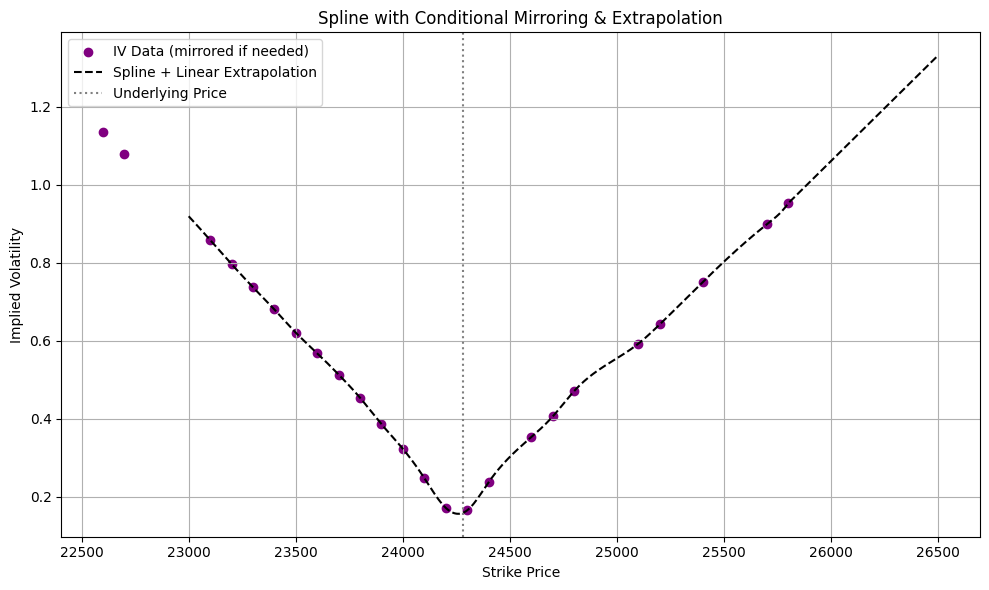

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.interpolate import CubicSpline

# Load data
df = pd.read_csv('train_data_masked.csv')
row = df.iloc[3200]  # Pick a row to analyze

# Extract IVs
iv_data = {}
for col in row.index:
    match = re.match(r'(call_iv_|put_iv_)(\d+)', col)
    if match:
        strike = int(match.group(2))
        iv = row[col]
        if pd.notna(iv):
            iv_data[strike] = iv

# Sort and convert to arrays
strikes, ivs = zip(*sorted(iv_data.items()))
strikes = np.array(strikes)
ivs = np.array(ivs)

# Extract underlying price
underlying_price = row['underlying']
idx_underlying = np.abs(strikes - underlying_price).argmin()
strike_underlying = strikes[idx_underlying]
iv_underlying = ivs[idx_underlying]

# Count values on each side of underlying
left_mask = strikes < underlying_price
right_mask = strikes > underlying_price
num_left = np.sum(left_mask)
num_right = np.sum(right_mask)

# Mirror if fewer than 2 values on either side
if num_left < 2:
    mirror_strikes = 2 * underlying_price - strikes[right_mask]
    mirror_ivs = ivs[right_mask]
    strikes = np.concatenate([strikes, mirror_strikes])
    ivs = np.concatenate([ivs, mirror_ivs])
elif num_right < 2:
    mirror_strikes = 2 * underlying_price - strikes[left_mask]
    mirror_ivs = ivs[left_mask]
    strikes = np.concatenate([mirror_strikes, strikes])
    ivs = np.concatenate([mirror_ivs, ivs])

# Sort after mirroring
sorted_idx = np.argsort(strikes)
strikes = strikes[sorted_idx]
ivs = ivs[sorted_idx]

# Recompute underlying info
idx_underlying = np.abs(strikes - underlying_price).argmin()
strike_underlying = strikes[idx_underlying]
iv_underlying = ivs[idx_underlying]

# Estimate slope left
for i in range(1, len(strikes)):
    if strikes[i] != strikes[0]:
        slope_left_linear = (ivs[i] - ivs[0]) / (strikes[i] - strikes[0])
        if strike_underlying != strikes[0]:
            slope_left = 1.5 * (iv_underlying - ivs[0]) / (strike_underlying - strikes[0])
        else:
            slope_left = slope_left_linear
        break

# Estimate slope right
for i in range(1, len(strikes)):
    if strikes[-i - 1] != strikes[-1]:
        slope_right_linear = (ivs[-1] - ivs[-i - 1]) / (strikes[-1] - strikes[-i - 1])
        if strike_underlying != strikes[-1]:
            slope_right = 1.5 * (ivs[-1] - iv_underlying) / (strikes[-1] - strike_underlying)
        else:
            slope_right = slope_right_linear
        break

# Fit spline
spline = CubicSpline(strikes, ivs, bc_type=((1, slope_left), (1, slope_right)), extrapolate=False)

# Evaluate
x_smooth = np.linspace(23000, 26500, 1000)
y_smooth = np.empty_like(x_smooth)

s1, iv1 = strikes[0], ivs[0]
sN, ivN = strikes[-1], ivs[-1]

for i, x in enumerate(x_smooth):
    if x < s1:
        y_smooth[i] = iv1 + slope_left_linear * (x - s1)
    elif x > sN:
        y_smooth[i] = ivN + slope_right_linear * (x - sN)
    else:
        y_smooth[i] = spline(x)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(strikes, ivs, color='purple', label='IV Data (mirrored if needed)')
plt.plot(x_smooth, y_smooth, color='black', linestyle='--', label='Spline + Linear Extrapolation')
plt.axvline(underlying_price, color='gray', linestyle=':', label='Underlying Price')

plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Spline with Conditional Mirroring & Extrapolation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from scipy.interpolate import CubicSpline

# -------------------------------
# 1. Load Data
# -------------------------------
train_df = pd.read_csv("train_data_small.csv")
test_df = pd.read_csv("test_data.csv")

# Identify IV columns
call_iv_cols = [col for col in train_df.columns if col.startswith("call_iv_")]
put_iv_cols = [col for col in train_df.columns if col.startswith("put_iv_")]
iv_cols = call_iv_cols + put_iv_cols
feature_cols = [col for col in train_df.columns if col.startswith("X")]

# -------------------------------
# 2. Prepare Training Data
# -------------------------------
X_train = train_df[feature_cols]
y_train = train_df[iv_cols]

# Drop rows where all IVs are missing
valid_rows = y_train.notna().sum(axis=1) >= 5
X_train = X_train[valid_rows]
y_train = y_train[valid_rows].fillna(y_train.mean())  # fill remaining missing IVs with column means

# -------------------------------
# 3. Train IV Model
# -------------------------------
model = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42))
model.fit(X_train, y_train)

# -------------------------------
# 4. Predict on Test Data
# -------------------------------
X_test = test_df[feature_cols]
iv_pred = pd.DataFrame(model.predict(X_test), columns=iv_cols)

# -------------------------------
# 5. Refine Predictions Using Spline Interpolation
# -------------------------------
refined_preds = []

for idx, row in test_df.iterrows():
    refined_row = {"timestamp": row["timestamp"]}
    underlying = row["underlying"]

    # Combine predictions with observed IVs
    pred_iv = iv_pred.loc[idx]
    actual_iv = row[iv_cols]
    combined_iv = actual_iv.combine_first(pred_iv)

    # Prepare for spline (call and put separately)
    def refine_iv(group_cols):
        known = [(int(col.split("_")[-1]), combined_iv[col]) for col in group_cols if pd.notna(combined_iv[col])]
        if len(known) < 4:
            return {col: combined_iv[col] for col in group_cols}
        known.sort()
        strikes, ivs = zip(*known)
        spline = CubicSpline(strikes, ivs, extrapolate=True)
        return {col: actual_iv[col] if pd.notna(actual_iv[col]) else spline(int(col.split("_")[-1])) for col in group_cols}

    refined_row.update(refine_iv(call_iv_cols))
    refined_row.update(refine_iv(put_iv_cols))
    refined_preds.append(refined_row)

# -------------------------------
# 6. Save Submission
# -------------------------------
submission_df = pd.DataFrame(refined_preds)
submission_df = submission_df[["timestamp"] + iv_cols]  # Ensure correct column order
submission_df.to_csv("v4.csv", index=False)
print("Submission saved to v4.csv")


KeyboardInterrupt: 

In [6]:
import pandas as pd

# Load the CSV
df = pd.read_csv('train_data_cleaned.csv')

# Ensure 'timestamp' is not excluded, we need it
timestamp_col = 'timestamp'
df_numeric = df.drop(columns=[timestamp_col], errors='ignore')

# Identify call and put IV columns
call_iv_cols = [col for col in df_numeric.columns if col.startswith("call_iv_")]
put_iv_cols = [col for col in df_numeric.columns if col.startswith("put_iv_")]

# Calculate averages
call_iv_avg = df_numeric[call_iv_cols].mean()
put_iv_avg = df_numeric[put_iv_cols].mean()

# Calculate overall average for call and put IVs
call_iv_overall_avg = call_iv_avg.mean()
put_iv_overall_avg = put_iv_avg.mean()

# Prepare output
output = ""

# Add overall IV averages
output += f"Overall average of call IVs: {call_iv_overall_avg:.6f}\n"
output += f"Overall average of put IVs: {put_iv_overall_avg:.6f}\n\n"

# Add average per strike
output += "Average per strike:\n"
for col in call_iv_cols:
    strike = col.split('_')[-1]
    output += f"{col}: {call_iv_avg[col]:.6f}\n"
    
for col in put_iv_cols:
    strike = col.split('_')[-1]
    output += f"{col}: {put_iv_avg[col]:.6f}\n"

output += "\n"

# Continue with min/max details
for column in df_numeric.columns:
    min_val = df[column].min()
    max_val = df[column].max()
    
    min_row = df[df[column] == min_val].iloc[0]
    max_row = df[df[column] == max_val].iloc[0]
    
    output += f"Column: {column}\n"
    output += f"  Min: {min_val} at {min_row[timestamp_col]}\n"
    output += f"  Max: {max_val} at {max_row[timestamp_col]}\n\n"

# Save to text file
with open('min_max_with_timestamps.txt', 'w') as f:
    f.write(output)

print("Detailed min, max, and average values saved to 'min_max_with_timestamps.txt'")


Detailed min, max, and average values saved to 'min_max_with_timestamps.txt'


In [4]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

# Load data
df = pd.read_csv('train_data.csv')

# Identify call and put IV columns
iv_cols = [col for col in df.columns if re.match(r'(call_iv_|put_iv_)\d+', col)]

# Set seed for reproducibility
np.random.seed(42)

# Apply clipping with individual random upper bounds per cell
for col in tqdm(iv_cols, desc="Clipping IV columns"):
    rand_upper = np.random.uniform(1, 2, size=len(df))
    df[col] = df[col].clip(lower=0.05)
    df[col] = np.minimum(df[col], rand_upper)

# Save cleaned data
df.to_csv('train_data_cleaned.csv', index=False)
print("Saved cleaned data to train_data_cleaned.csv")


Clipping IV columns: 100%|██████████| 52/52 [00:00<00:00, 200.21it/s]


Saved cleaned data to train_data_cleaned.csv


In [1]:
import pandas as pd

# Load original CSV
df = pd.read_csv("corrected_test_ivs.csv")

# Define strike ranges
call_strikes = list(range(24000, 26600, 100))  # 24000 to 26500
put_strikes = list(range(23000, 25600, 100))   # 23000 to 25500

# Initialize new DataFrame with timestamp
df_new = pd.DataFrame()
df_new["timestamp"] = df["timestamp"]

# Add call_iv columns
for strike in call_strikes:
    col_name = f"iv_{strike}"
    new_col = f"call_iv_{strike}"
    if col_name in df.columns:
        df_new[new_col] = df[col_name]
    else:
        df_new[new_col] = None  # Fill with NaN if missing

# Add put_iv columns
for strike in put_strikes:
    col_name = f"iv_{strike}"
    new_col = f"put_iv_{strike}"
    if col_name in df.columns:
        df_new[new_col] = df[col_name]
    else:
        df_new[new_col] = None  # Fill with NaN if missing

# Save to new CSV
df_new.to_csv("v6.csv", index=False)


In [7]:
import pandas as pd

# Load both CSVs
df_v6 = pd.read_csv("sub_new.csv")
df_v4 = pd.read_csv("v4.csv")

# Ensure both dataframes are aligned by timestamp
df_v6.set_index("timestamp", inplace=True)
df_v4.set_index("timestamp", inplace=True)

# Fill missing values in v6 using v4
df_filled = df_v6.fillna(df_v4)

# Reset index and save to new CSV
df_filled.reset_index(inplace=True)
df_filled.to_csv("sub_new.csv", index=False)


In [19]:
import pandas as pd
import re

# Load the data
df = pd.read_csv("train_data_cleaned.csv")

# Define strike ranges
strikes = list(range(22500, 26001, 100))
put_only = set(range(22500, 23500, 100))
call_only = set(range(25100, 26001, 100))
both = set(strikes) - put_only - call_only

# Prepare new DataFrame
df_out = df[['timestamp', 'underlying'] + [f'X{i}' for i in range(42)]].copy()

# Add iv columns
for strike in strikes:
    put_col = f"put_iv_{strike}"
    call_col = f"call_iv_{strike}"
    iv_col = f"iv_{strike}"

    if strike in put_only:
        df_out[iv_col] = df[put_col]
    elif strike in call_only:
        df_out[iv_col] = df[call_col]
    else:  # average where both available
        df_out[iv_col] = df[[put_col, call_col]].mean(axis=1)

# Reorder columns as specified
iv_cols = [f"iv_{strike}" for strike in strikes]
final_columns = ['timestamp', 'underlying'] + iv_cols + [f'X{i}' for i in range(42)]
df_out = df_out[final_columns]

# Save to CSV
df_out.to_csv("train_data_unified_iv.csv", index=False)


In [10]:
import pandas as pd
from tabulate import tabulate

# Load the CSV
df = pd.read_csv("train_data_cleaned_prev.csv")  # Replace with your actual file name

# Drop timestamp column if present
if 'timestamp' in df.columns:
    df = df.drop(columns=['timestamp'])

# Compute statistics
summary = df.describe().T

# Reorder columns for readability
summary = summary[['mean', 'min', 'max', 'std']]

# Save nicely formatted table
with open("iv_data_summary.txt", "w") as f:
    f.write(tabulate(summary, headers="keys", tablefmt="grid", floatfmt=".6f"))

print("Aligned summary table saved to iv_data_summary.txt")


Aligned summary table saved to iv_data_summary.txt


In [11]:
import pandas as pd
from tabulate import tabulate

# Load the CSV
df = pd.read_csv("test_data.csv")  # Replace with your actual file name

# Drop timestamp column if present
if 'timestamp' in df.columns:
    df = df.drop(columns=['timestamp'])

# Compute statistics
summary = df.describe().T

# Reorder columns for readability
summary = summary[['mean', 'min', 'max', 'std']]

# Save nicely formatted table
with open("test_iv_data_summary.txt", "w") as f:
    f.write(tabulate(summary, headers="keys", tablefmt="grid", floatfmt=".6f"))

print("Aligned summary table saved to test_iv_data_summary.txt")


Aligned summary table saved to test_iv_data_summary.txt


/tmp/ipykernel_22239/601485198.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma')


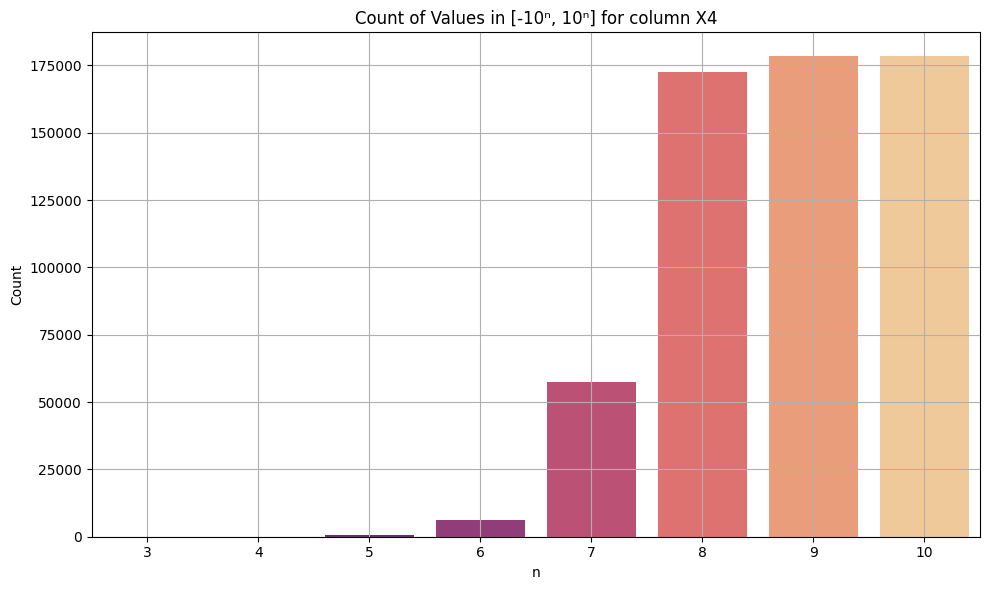

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load data
df = pd.read_csv('train_data_cleaned_prev.csv')
column_name = 'X4'
data = df[column_name].dropna().values

# Get maximum exponent needed
max_abs_val = np.max(np.abs(data))
max_n = int(np.ceil(np.log10(max_abs_val))) if max_abs_val > 0 else 0

counts_by_n = {}

# Count values within [-10^n, 10^n] for each n where count > 0
for n in range(max_n + 1):
    limit = 10 ** n
    count = np.sum(np.abs(data) <= limit)
    if count > 0:
        counts_by_n[n] = count

# Prepare DataFrame
plot_df = pd.DataFrame({
    'n': list(counts_by_n.keys()),
    'count': list(counts_by_n.values())
})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='n', y='count', data=plot_df, palette='magma')
plt.title(f'Count of Values in [-10ⁿ, 10ⁿ] for column {column_name}')
plt.xlabel('n')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
import pandas as pd
import numpy as np

# Load CSV
df = pd.read_csv("train_data_cleaned.csv")

# Identify columns starting with 'X'
x_cols = [col for col in df.columns if col.startswith('X')]

for col in x_cols:
    abs_vals = df[col].abs()
    pct_below_10 = (abs_vals < 10).mean()

    if pct_below_10 >= 0.96:
        mask = abs_vals < 10
        if mask.any():
            mean_within_range = df.loc[mask, col].mean()
            df.loc[abs_vals > 10, col] = mean_within_range
        else:
            print(f"Skipped {col}: no values with |x| < 10")
    else:
        # Log transformation with sign preservation
        df[col] = np.sign(df[col]) * np.log(abs_vals.clip(lower=1e-6)) * 10
        print(f"Applied log transformation to {col}")

# Save updated DataFrame
df.to_csv("train_data_cleaned.csv", index=False)

print("Completed column-wise replacements and transformations.")


Applied log transformation to X2
Applied log transformation to X4
Applied log transformation to X8
Applied log transformation to X10
Applied log transformation to X12
Applied log transformation to X14
Applied log transformation to X16
Applied log transformation to X17
Applied log transformation to X19
Applied log transformation to X20
Applied log transformation to X21
Applied log transformation to X23
Applied log transformation to X24
Applied log transformation to X27
Applied log transformation to X30
Applied log transformation to X31
Applied log transformation to X34
Applied log transformation to X38
Applied log transformation to X39
Applied log transformation to X40
Applied log transformation to X41
Completed column-wise replacements and transformations.


In [46]:
import pandas as pd
import numpy as np

# Load your unified CSV
df = pd.read_csv("train_data_unified_iv.csv")

# Identify all IV columns (starting with 'iv_')
iv_cols = [col for col in df.columns if col.startswith('iv_')]

# Set a random seed for reproducibility
np.random.seed(42)

# Mask 50% of each IV column
for col in iv_cols:
    mask = np.random.rand(len(df)) < 0.5  # Randomly choose ~50% of the rows
    df.loc[mask, col] = np.nan

# Save masked DataFrame
df.to_csv("train_data_unified_iv_masked.csv", index=False)

print("50% of values in IV columns have been masked and saved.")


50% of values in IV columns have been masked and saved.


In [ ]:
import pandas as pd

# Load both CSVs
df_test = pd.read_csv("new_test_data_filtered.csv")
df_v4 = pd.read_csv("v4.csv")

# List of columns to copy from test_data
columns_to_add = ['underlying'] + ['X1', 'X3', 'X4', 'X9', 'X12', 'X16', 'X17', 'X18', 'X23', 'X26', 'X32', 'X33', 'X34', 'X35', 'X37', 'X38']

# Get all IV columns (they should stay between timestamp and feature columns)
iv_cols = [col for col in df_v4.columns if col.startswith('call_iv_') or col.startswith('put_iv_')]

# Create a new DataFrame with the desired column order
result_df = pd.DataFrame()
result_df['timestamp'] = df_v4['timestamp']
result_df['underlying'] = df_test['underlying']
result_df[iv_cols] = df_v4[iv_cols]

# Add feature columns at the end
for col in columns_to_add[1:]:  # Skip 'underlying' as it's already added
    result_df[col] = df_test[col]

# Save the result
result_df.to_csv("new_v4_with_filtered.csv", index=False)


In [22]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('v4_final.csv')

# Define columns to remove: 'underlying' and 'X0' to 'X41'
columns_to_remove = ['underlying'] + ['X1', 'X3', 'X4', 'X9', 'X12', 'X16', 'X17', 'X18', 'X23', 'X26', 'X32', 'X33', 'X34', 'X35', 'X37', 'X38']

# Drop the columns if they exist in the DataFrame
df = df.drop(columns=[col for col in columns_to_remove if col in df.columns])

# Save the cleaned DataFrame to a new CSV
df.to_csv('new_v4_final.csv', index=False)

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


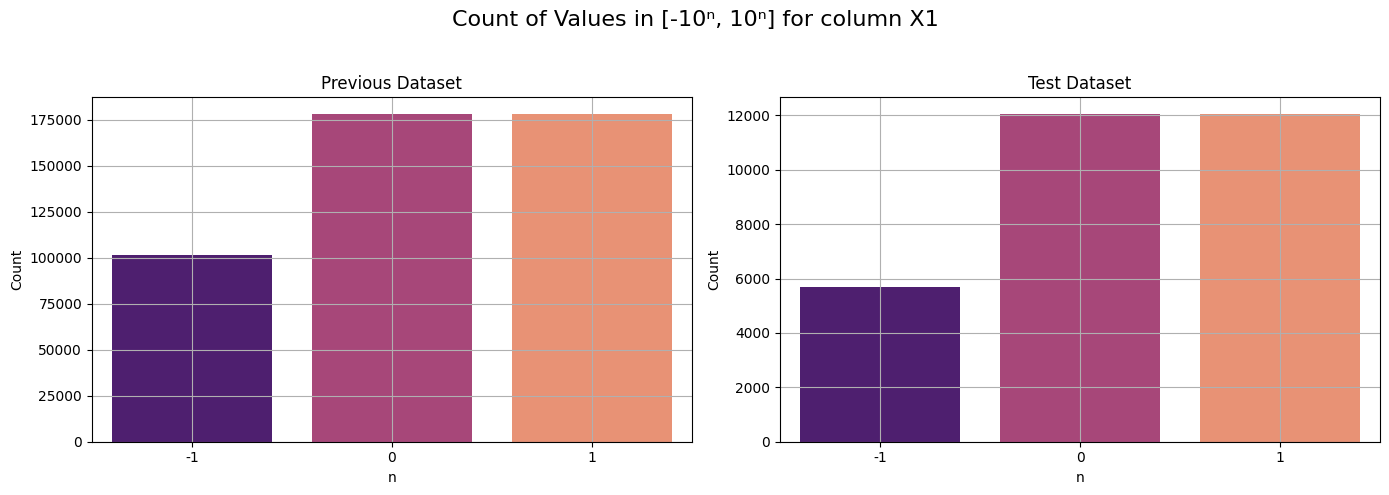

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


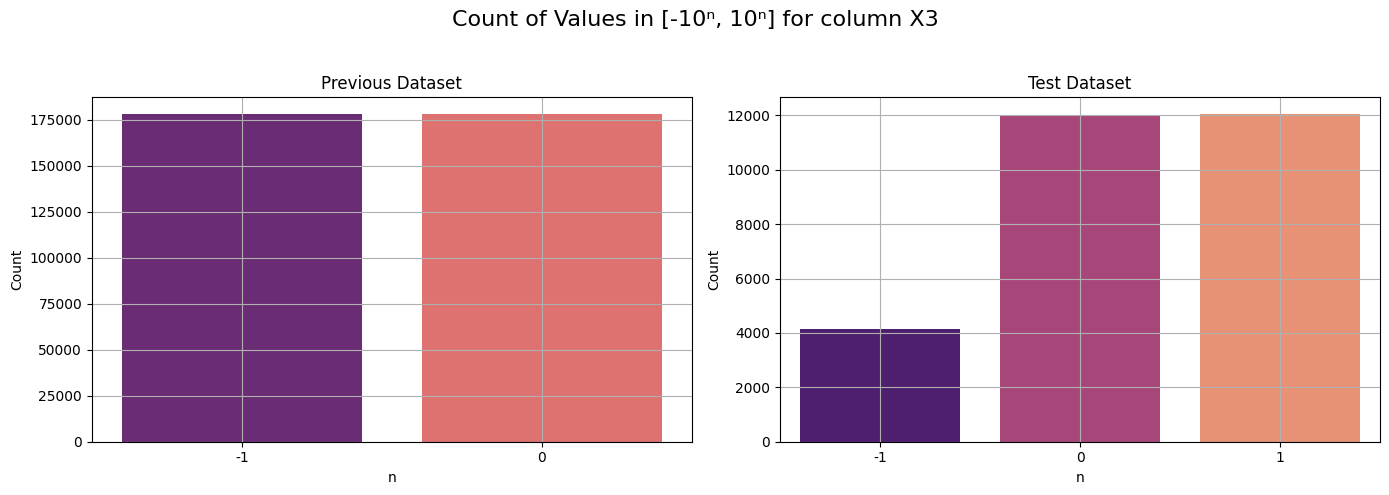

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


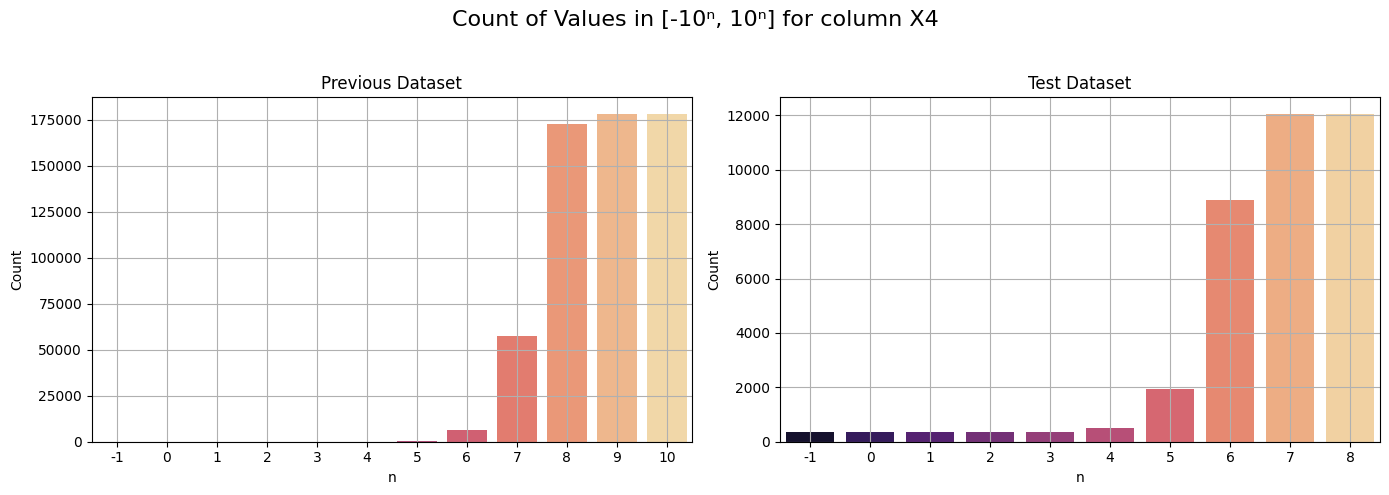

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


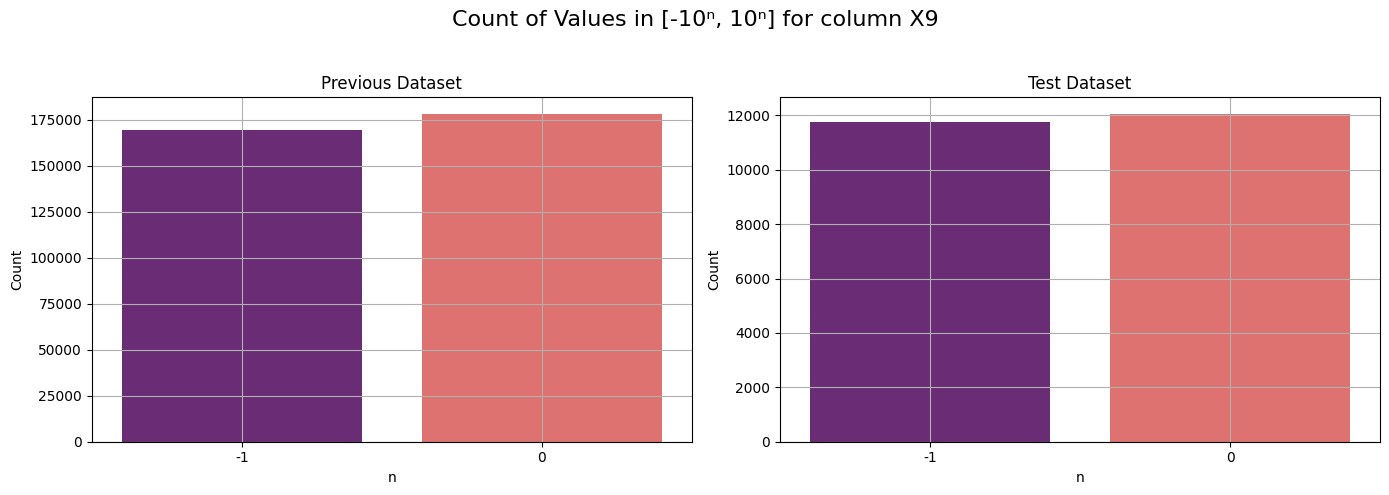

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


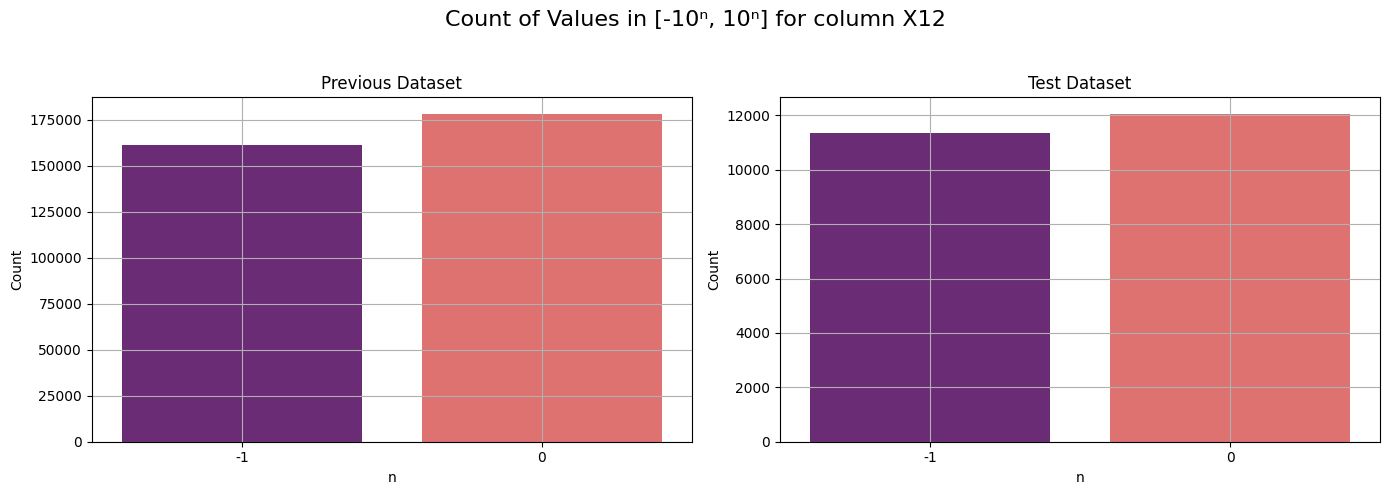

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


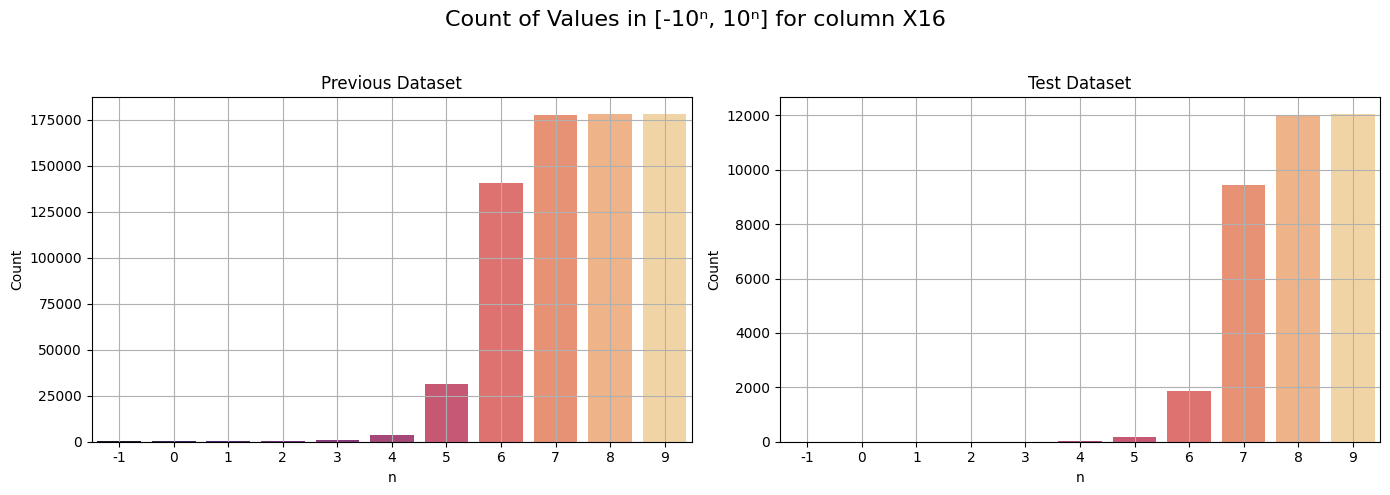

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


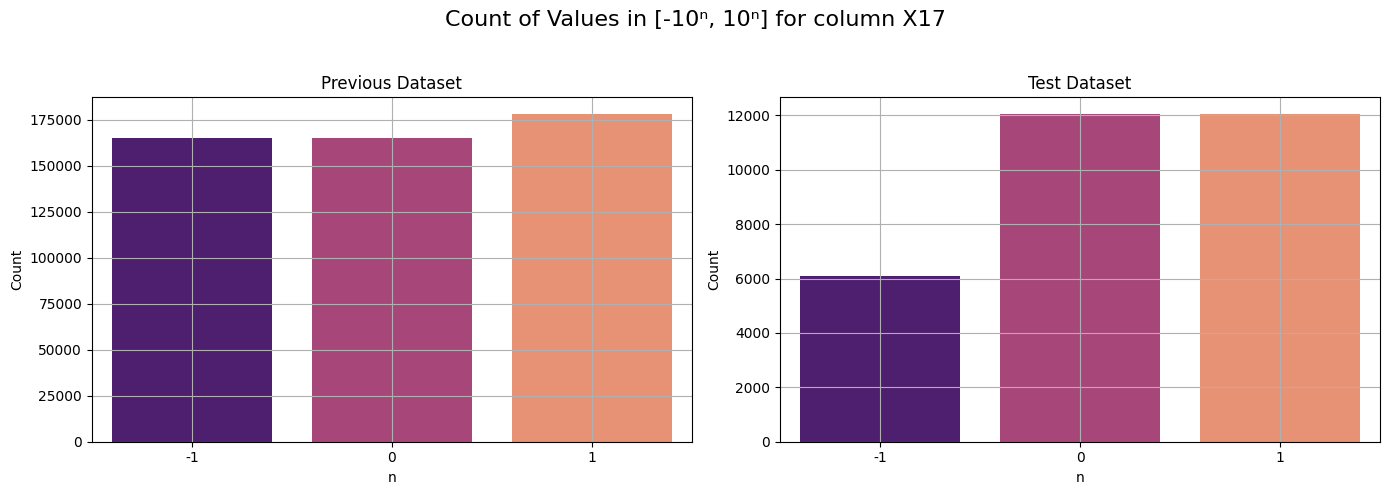

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


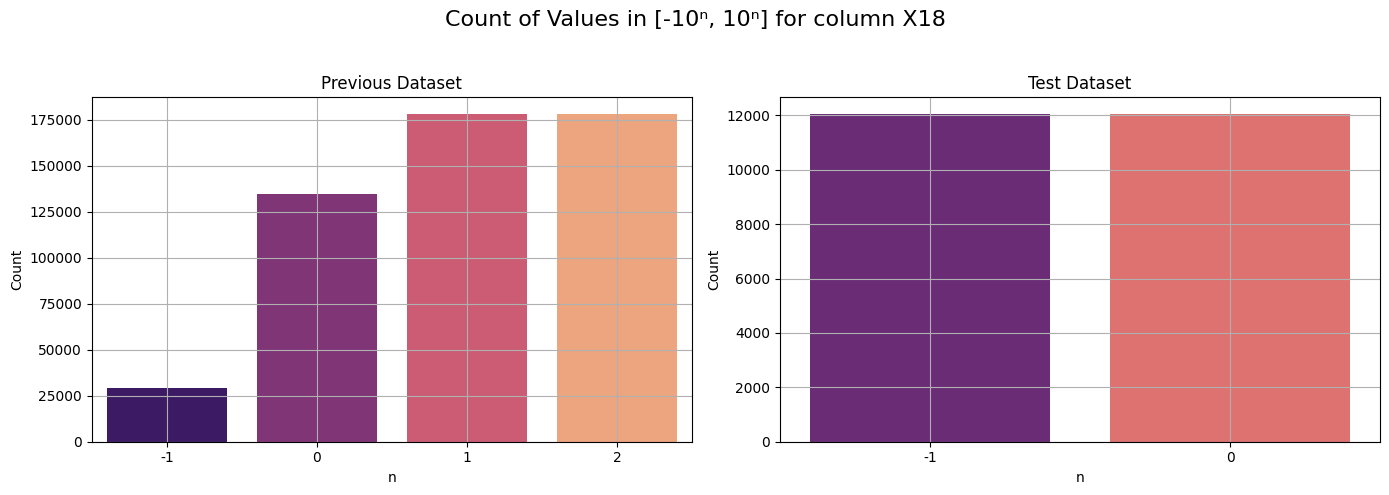

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


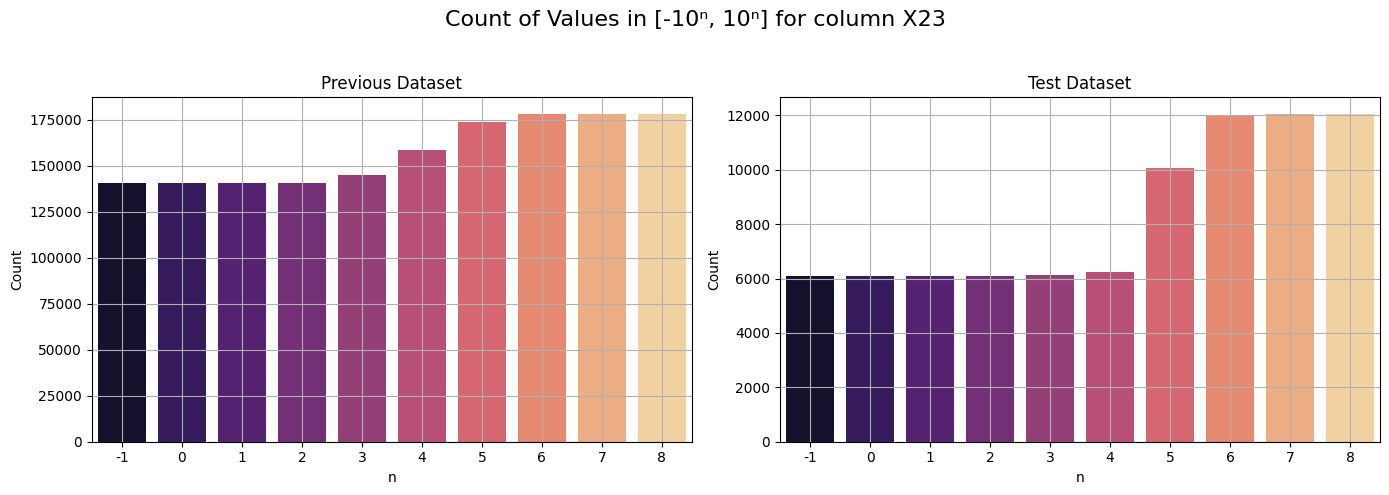

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


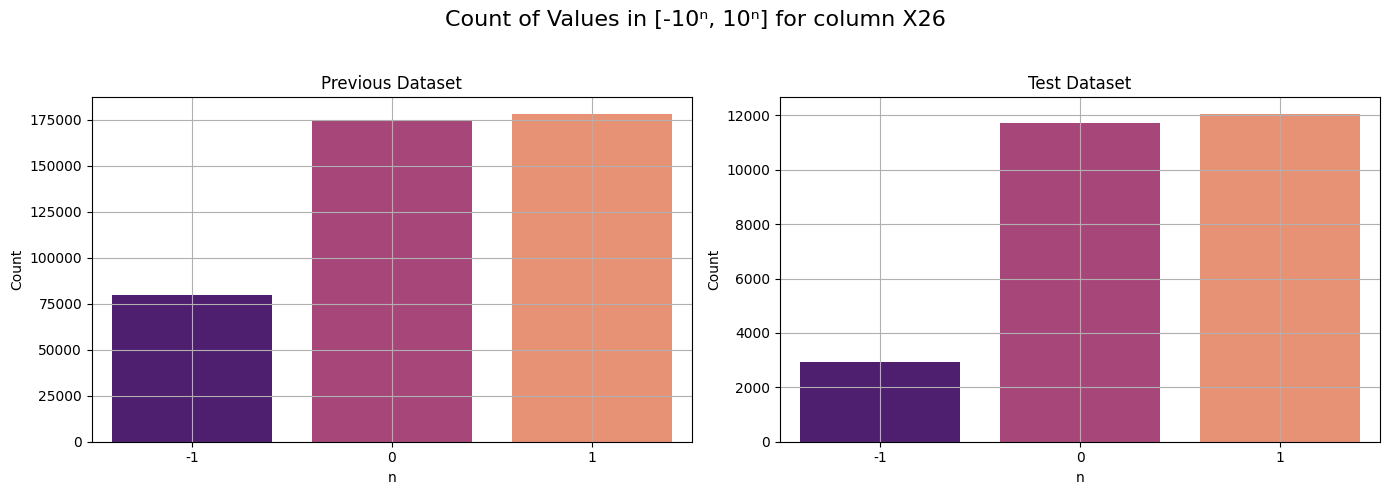

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


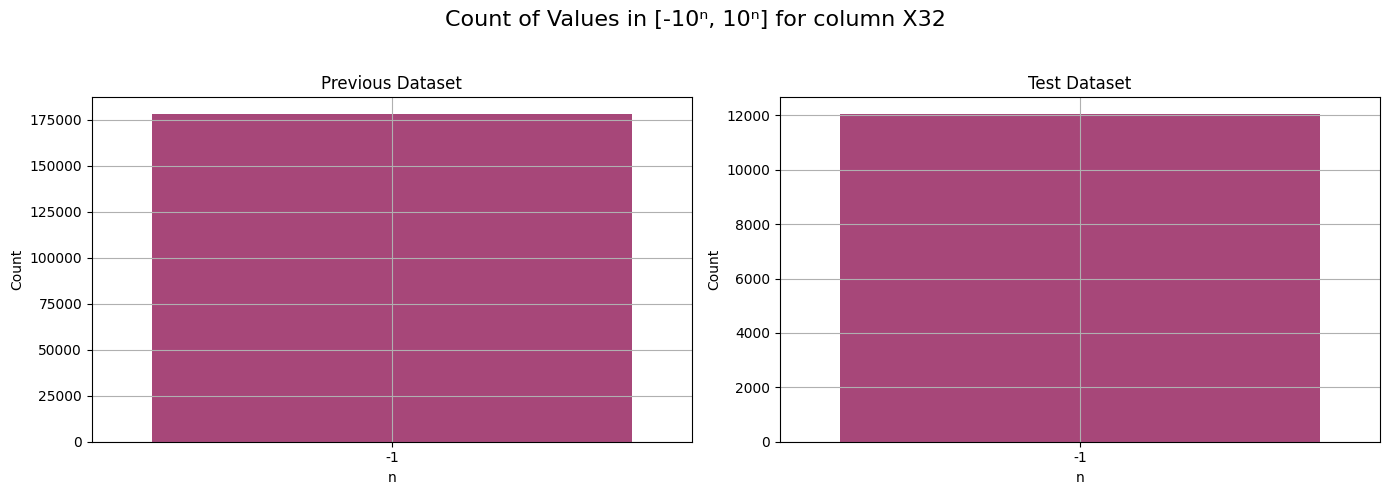

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


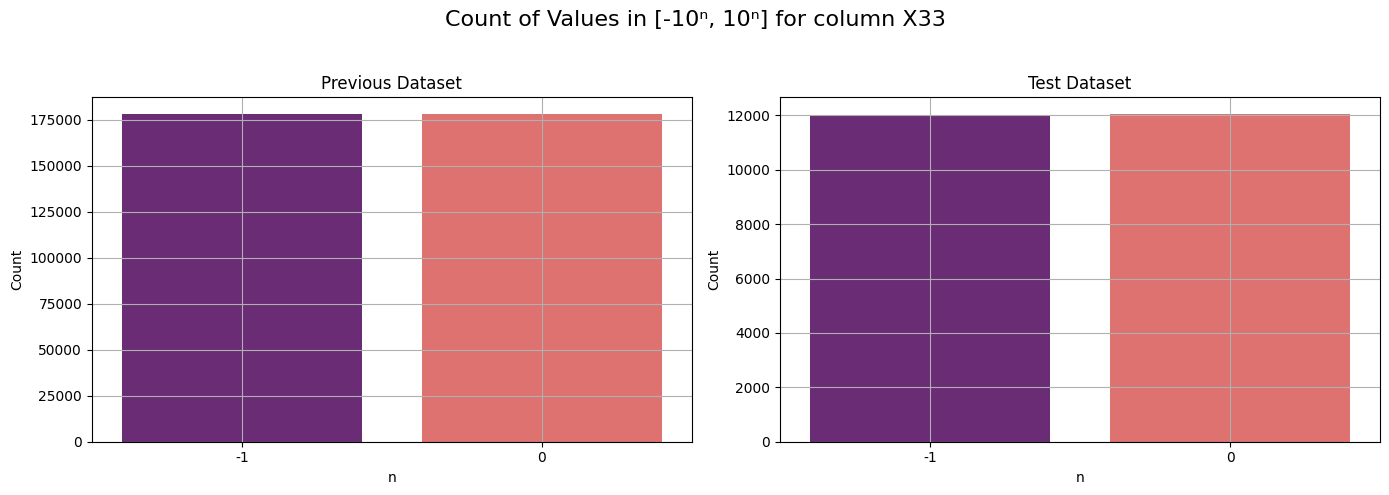

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


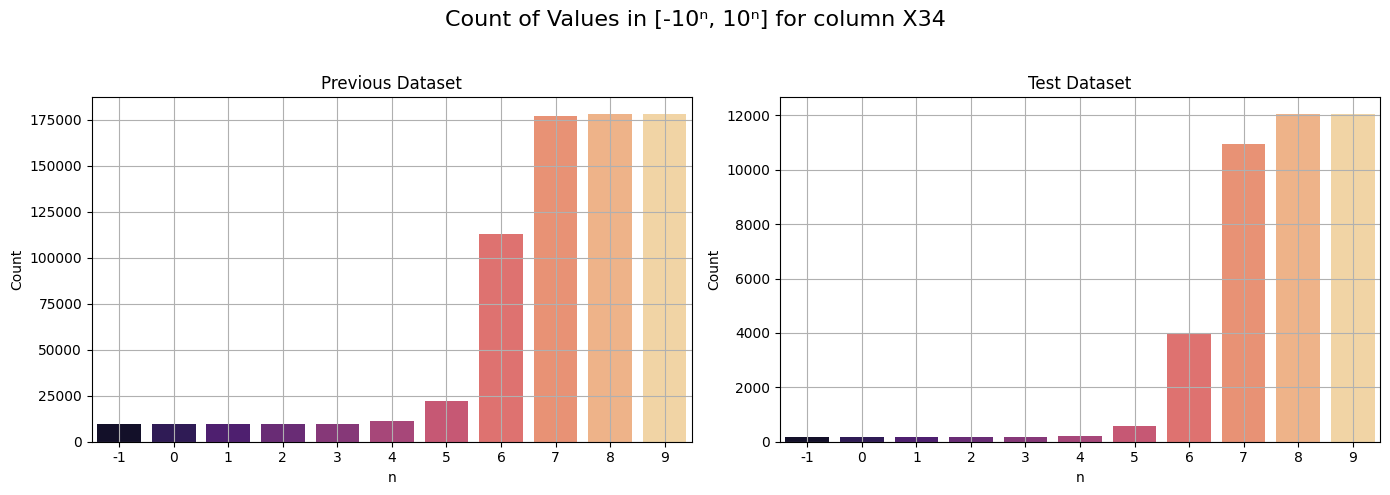

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


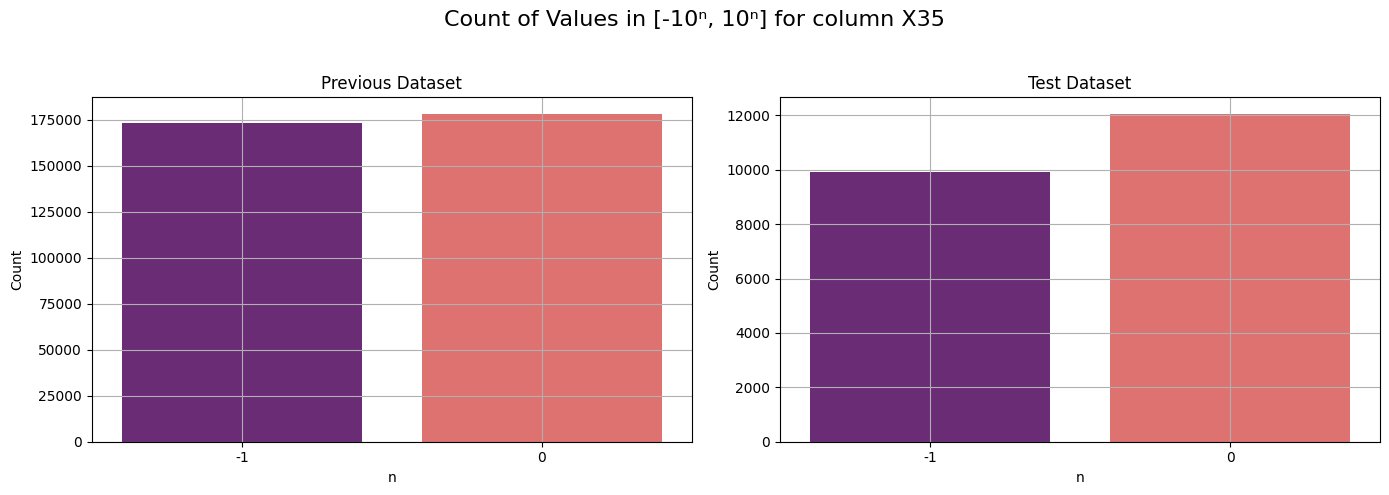

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


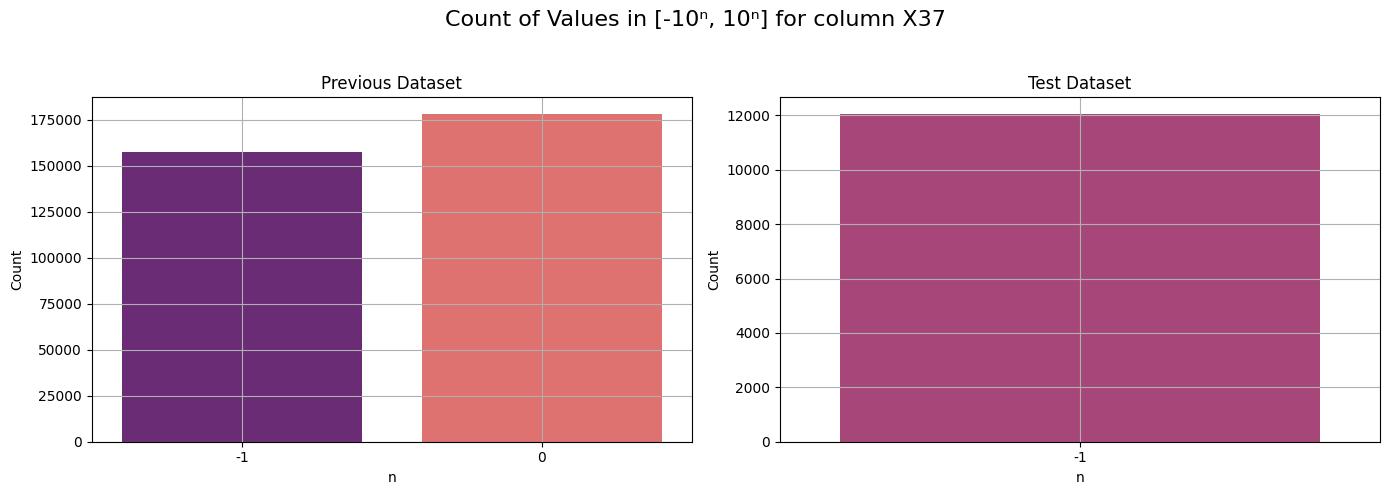

/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
/tmp/ipykernel_157655/2456401784.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])


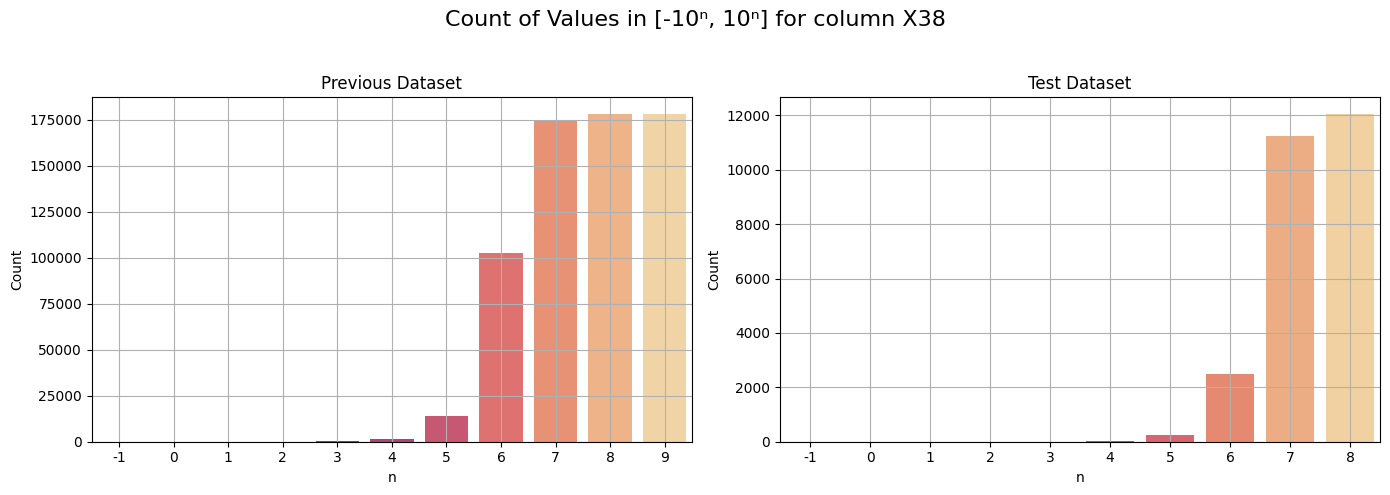

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Settings
file_paths = ['new_train_data.csv', 'new_test_data.csv']
titles = ['Previous Dataset', 'Test Dataset']
dfs = [pd.read_csv(path) for path in file_paths]

# Selected features only
selected_features = ['X1', 'X3', 'X4', 'X9', 'X12', 'X16', 'X17', 'X18', 'X23', 'X26', 'X32', 'X33', 'X34', 'X35', 'X37', 'X38']

# Loop over selected columns
for column_name in selected_features:

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Individual y-axes
    fig.suptitle(f'Count of Values in [-10ⁿ, 10ⁿ] for column {column_name}', fontsize=16)

    for j, (df, title) in enumerate(zip(dfs, titles)):
        if column_name not in df.columns:
            axes[j].set_title(f"{title} (Column not found)")
            axes[j].axis('off')
            continue

        data = df[column_name].dropna().values
        if len(data) == 0:
            axes[j].set_title(f"{title} (No non-NaN data)")
            axes[j].axis('off')
            continue

        max_abs_val = np.max(np.abs(data))
        max_n = int(np.ceil(np.log10(max_abs_val))) if max_abs_val > 0 else 0

        counts_by_n = {}

        # Start from n = -1 to include 10^-1
        for n in range(-1, max_n + 1):
            limit = 10 ** n
            count = np.sum(np.abs(data) <= limit)
            counts_by_n[n] = count

        plot_df = pd.DataFrame({
            'n': list(counts_by_n.keys()),
            'count': list(counts_by_n.values())
        })

        sns.barplot(x='n', y='count', data=plot_df, palette='magma', ax=axes[j])
        axes[j].set_title(title)
        axes[j].set_xlabel('n')
        axes[j].set_ylabel('Count')
        axes[j].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [11]:
import pandas as pd
import numpy as np

# Load your CSV
# df = pd.read_csv('test_data.csv')
df = pd.read_csv('train_data_cleaned_prev.csv')

# Parameters
column_name = 'X37'  # Replace with your column name
x = 0.5  # Threshold magnitude
y = 0.5   # Replacement value

# Replace values with magnitude > x with y, preserving original sign
df[column_name] = df[column_name].apply(
    lambda val: np.sign(val) * y if abs(val) > x else val
)

# Save or view the result
# df.to_csv('test_data.csv', index=False)
df.to_csv('train_data_cleaned_prev.csv', index=False)


In [13]:
import pandas as pd

# Load your CSV
df = pd.read_csv('new_test_data.csv')

# List of X-columns you want to keep
keep_cols = ['X1', 'X3', 'X4', 'X9', 'X12', 'X16', 'X17', 'X18', 'X23', 'X26', 'X32', 'X33', 'X34', 'X35', 'X37', 'X38']

# Drop all columns starting with 'X' that are NOT in keep_cols
df = df.drop(columns=[col for col in df.columns if col.startswith('X') and col not in keep_cols])

# Save the cleaned DataFrame
df.to_csv('new_test_data_filtered.csv', index=False)


In [15]:
import pandas as pd

# Load cleaned X data
x_data = pd.read_csv('new_train_data_filtered.csv')

# Ensure we only get columns that start with 'X'
x_data = x_data.loc[:, x_data.columns.str.startswith('X')]

# Load base CSV
base_df = pd.read_csv('train_data_unified_iv.csv')

# Drop all columns in base_df that start with 'X'
base_df = base_df.drop(columns=[col for col in base_df.columns if col.startswith('X')])

# Concatenate base_df with the X columns
merged_df = pd.concat([base_df, x_data], axis=1)

# Save to a new file
merged_df.to_csv('new_train_unified_filtered.csv', index=False)


In [18]:
import pandas as pd
import numpy as np

# Load the CSV
df = pd.read_csv('new_train_residuals_masked_filtered.csv')

# Replace both string 'nan' and actual NaN values with empty string
df = df.replace('nan', '')       # replace string 'nan'
df = df.replace(np.nan, '', regex=True)  # replace actual NaN

# Convert timestamp to int (if it's numeric)
df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce').astype('Int64')

# Optional: convert to int and drop NA if any invalids
df['timestamp'] = df['timestamp'].fillna(0).astype(int)

# Save cleaned version
df.to_csv('new_train_residuals_masked_filtered2.csv', index=False)


In [23]:
import pandas as pd

# Load both CSVs
source_df = pd.read_csv('v4.csv')
target_df = pd.read_csv('new_v4_final.csv')

# Columns to replace
columns_to_replace = ['call_iv_26100', 'call_iv_26200', 'call_iv_26300', 'call_iv_26400', 'call_iv_26500', 'put_iv_23000', 'put_iv_23100', 'put_iv_23200', 'put_iv_23300', 'put_iv_23400']

# Replace in target only if columns exist in both
for col in columns_to_replace:
    if col in source_df.columns and col in target_df.columns:
        target_df[col] = source_df[col]

# Save the updated target CSV
target_df.to_csv('updated_new_v4_final.csv', index=False)


Mean of the column: 24891.450285951098


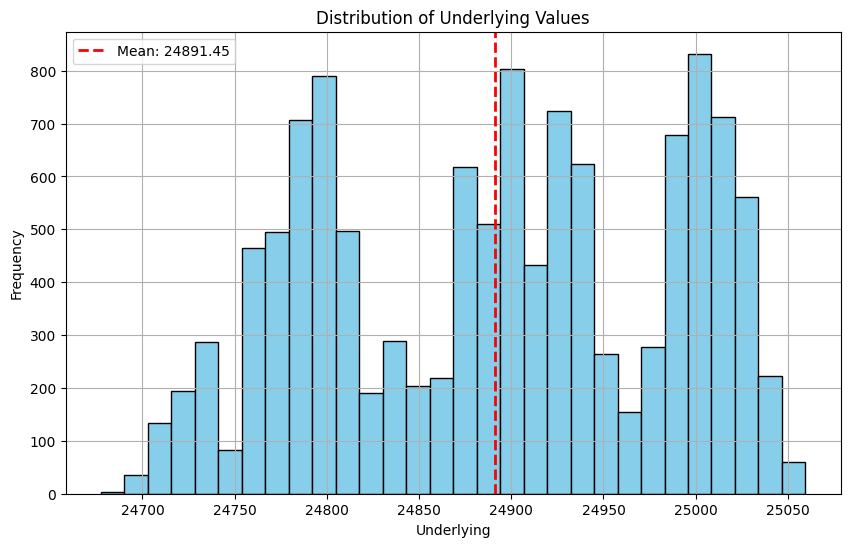

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('new_test_data_filtered.csv')

# Calculate the mean
mean_value = df['underlying'].mean()
print(f"Mean of the column: {mean_value}")

# Plotting the distribution of the 'underlying' column
plt.figure(figsize=(10, 6))
plt.hist(df['underlying'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.title('Distribution of Underlying Values')
plt.xlabel('Underlying')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('v4_distance_corrected.csv')  # Replace with your actual file

# Drop 'underlying' and columns starting with 'X'
df = df.drop(columns=[col for col in df.columns if col == 'underlying' or col.startswith('X')])

# Save the modified DataFrame to a new CSV
df.to_csv('v4_distance_corrected.csv', index=False)

print("Removed 'underlying' and columns starting with 'X'. Saved to 'v4_distance_corrected.csv'.")


Removed 'underlying' and columns starting with 'X'. Saved to 'v4_distance_corrected.csv'.


In [13]:
import pandas as pd

# Load both CSV files
df_a = pd.read_csv('new_test_data.csv')   # Has missing values but more accurate
df_b = pd.read_csv('v4_distance_corrected.csv')    # Complete data but less accurate

# Only consider columns that exist in B
common_columns = df_b.columns.intersection(df_a.columns)

# Update B with non-missing values from A, only for shared columns
df_b[common_columns] = df_b[common_columns].where(df_a[common_columns].isna(), df_a[common_columns])

# Save the updated B to a new file
df_b.to_csv('v4_distance_corrected_updated.csv', index=False)

print("Updated B with non-missing values from A for shared columns. Saved as 'v4_distance_corrected_updated.csv'.")


Updated B with non-missing values from A for shared columns. Saved as 'v4_distance_corrected_updated.csv'.
